# Red Wine Quality 
## Statistical Modeling

<u>Notebook Goals</u>:<br>
- Use linear models to predict red wine quality and alcohol content 
- Assess linear models statistically

### Import Relevant Modules and Utility Functions

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_partregress_grid
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    f1_score,
    mean_squared_error,
    r2_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

from utils.plots import (
    plot_correlations,
    plot_feature_boxplot,
    plot_feature_distribution,
    plot_feature_qqplot,
    plot_permutations,
    plot_actual_vs_predicted,
    plot_residuals,
    plot_roc_curve,
)
from utils.statistics import (
    chi_square_test_train,
    bootstrap_confidence_interval_two_means,
    mean_diff_permutation,
)

Import Data

In [2]:
os.makedirs('data', exist_ok=True)
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009 -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009
License(s): DbCL-1.0
  0%|                                               | 0.00/25.6k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 25.6k/25.6k [00:00<00:00, 2.53MB/s]


### Exploratory Data Analysis

In [3]:
wine_quality = pd.read_csv("./data/winequality-red.csv")
wine_quality.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [4]:
n_wines = wine_quality.shape[0]
n_features = wine_quality.shape[1]

print(
    f"The following dataset contains {n_wines} wines and {n_features} features about those wines."
)

The following dataset contains 1599 wines and 12 features about those wines.


In [5]:
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


It appears that this dataset is complete and does not have any missing information. 

In [6]:
wine_quality.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


At first glance:
- there is no observation that looks strikingly non-normal (except for "quality") 
- each feature is a continuous quantitative measurement except "quality" 
- mean and median values are close for most features, an exception being "total sulfur dioxide" 
- looking at the differences between min and max values and 25%-ile and 75%-ile, respectively, it does appear like there are likely to be positive outliers for many features. 

In [7]:
quality = sorted(wine_quality["quality"].unique())
print(
    f"The wines in this dataset have received the following quality scores: \n {quality} out of 10."
)
print("Below are the frequencies of each score:")
wine_quality["quality"].value_counts().sort_index()

The wines in this dataset have received the following quality scores: 
 [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] out of 10.
Below are the frequencies of each score:


quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

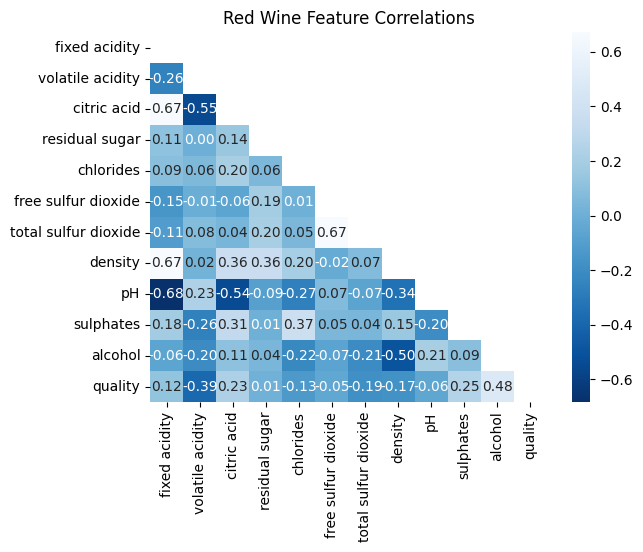

In [9]:
fig, ax = plot_correlations(wine_quality, "Red Wine Feature Correlations")

Many features appear to be correlated, this will be important when considering multicollinearity while generating a model. I will reference this plot in order to refine feature selection in later steps. 

In [10]:
features = wine_quality.columns.values

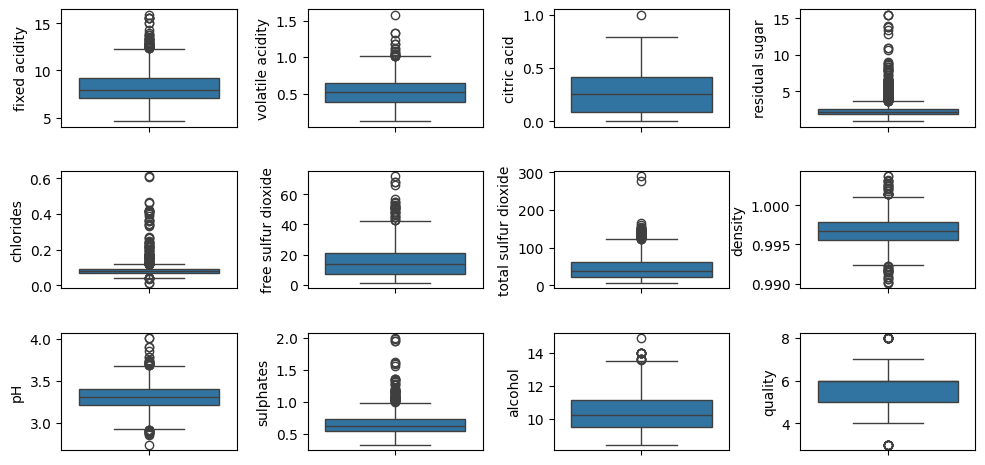

In [11]:
fig, axes = plot_feature_boxplot(features, wine_quality)

Several of these features contain a large number of positive outliers, especially residual sugar.

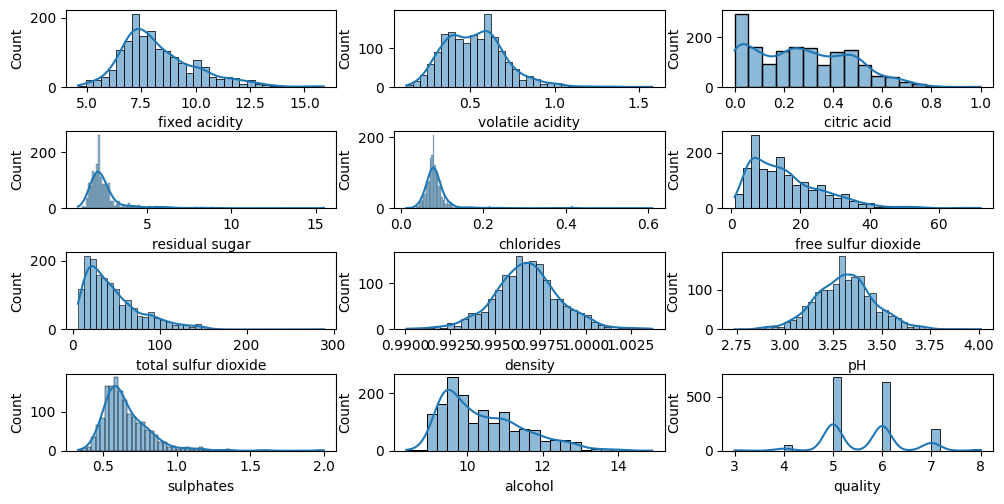

In [12]:
fig, axes = plot_feature_distribution(features, wine_quality)

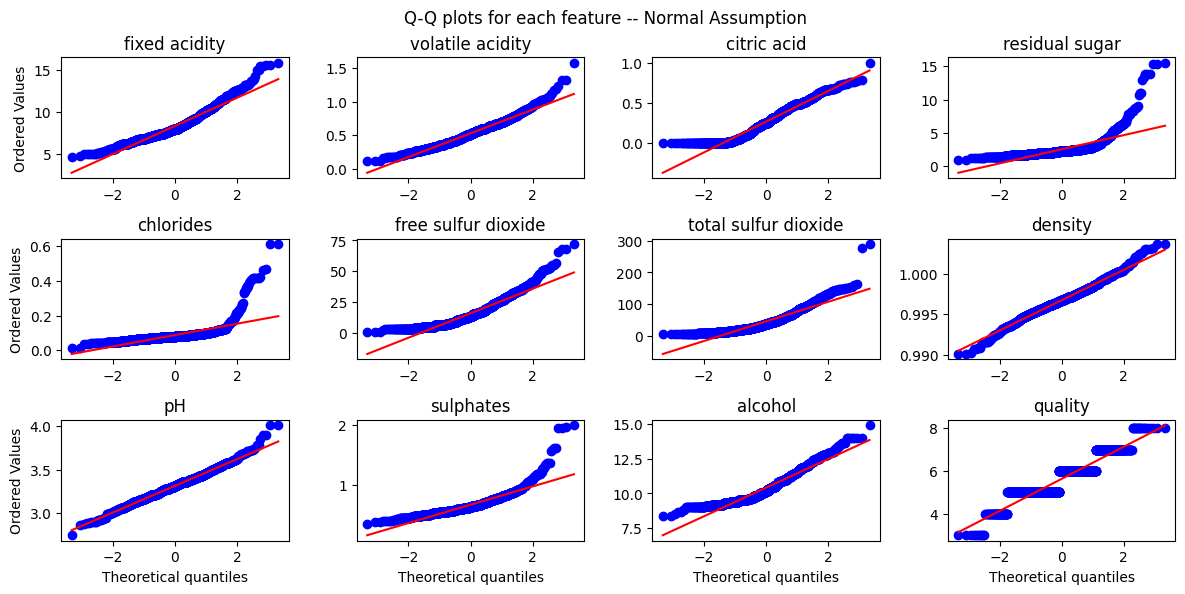

In [13]:
fig, axes = plot_feature_qqplot(features, wine_quality)

Quality is clearly not a continuous variable.<br>Most variables do not appear to be normally distributed. <br>However, pH and density appear the most normal. 

### Linear Modeling

I will split my data into training data (80%) and testing data (20%) and ensure a balance of the outcome variable

In [17]:
train_data, test_data = train_test_split(wine_quality, test_size=0.2, stratify=wine_quality.loc[:, 'quality'])
train_total = train_data.shape[0]
test_total = test_data.shape[0]

I will perform hypothesis testing to ensure that the test_train_split function pulls the data from a common distribution

In [20]:
chi_square_test_train(train_data, test_data)

Chi-squared statistic: 0.0003027800274814209
P-value: 0.9999999999151562
Fail to reject null hypothesis: There is no significant difference in the distribution of the categorical variable between the two datasets.


The Q-Q plots in the previous section show that our outcome variables (Quality and Alcohol) are not normally distributed. Hence, I will use appropriate methods (i.e. resampling methods) to investigate these variables. 

In [22]:
low_ci, up_ci = bootstrap_confidence_interval_two_means(train_data["alcohol"], test_data["alcohol"])
print(f"95% Bootstrap Confidence Interval: ({low_ci:.2f}, {up_ci:.2f})")

95% Bootstrap Confidence Interval: (-0.16, 0.12)


In [23]:
best_estimate = train_data["alcohol"].mean() - test_data["alcohol"].mean()
combined_series = pd.concat(
    [train_data["alcohol"], test_data["alcohol"]], ignore_index=True
)
perm_diffs = [
    mean_diff_permutation(combined_series, train_total, test_total) for _ in range(1000)
]

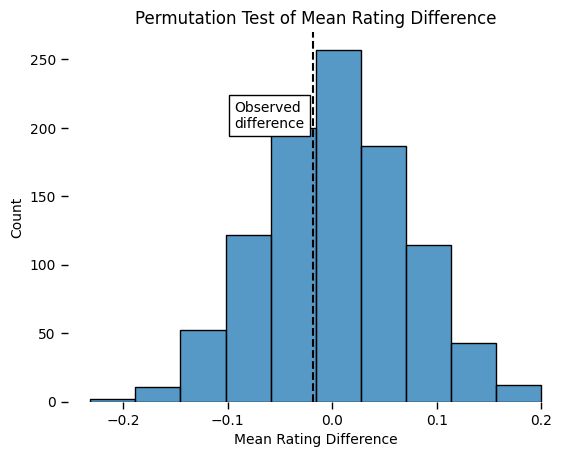

In [24]:
ax = plot_permutations(perm_diffs, best_estimate)

In [25]:
p_value = np.mean([diff > best_estimate for diff in perm_diffs])
print(
    f"""
According to this permutation test the difference in the means 
that we observed would be observed due to chance {p_value*100}% of the time, p = {p_value}.
"""
)


According to this permutation test the difference in the means 
that we observed would be observed due to chance 62.5% of the time, p = 0.625.



I have run these permutation tests multiple times and what I have observed is that occasionally you do not get data that looks like it comes from a common distribution (that is, similar to chance variation), but a majority of the time when I run the preceding blocks of code, this train-test split does appear to pull data that has a confidence interval that includes 0 and a mean rating difference near 0. Which suggests that the data is split in a balanced way. 

####  Can I predict the column "quality" from the other features? 
note: quality is an ordinal categorical variable that can only take on integer values 1-10, not a continuous variable. 

However, I will still start with a simple regression model. 

First, I will include every feature into the model and use manual feature selection based on hypothesis testing <br> $H_0: \beta_0  = \beta_1 = \beta_2 = ... = \beta_k = 0$ <br>
 $H_1 = \beta_j \neq 0 $ for at least one $j$ <br>
Significance level:  $\alpha = 0.05$ <br>
And use the correlation matrix earlier in the notebook to them remove features that are likely to be collinear. 
<br>
***
<br>
note: For practice, I have chosen to use a combination of statsmodels and scikit-learn. Hence, some redundancy in the notebook. 

In [26]:
model = smf.ols(
    formula='quality ~ Q("fixed acidity") + Q("volatile acidity") + Q("citric acid") + Q("residual sugar") + chlorides + Q("free sulfur dioxide") + Q("total sulfur dioxide") + density + pH + sulphates + alcohol',
    data=train_data,
)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     64.19
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          1.06e-113
Time:                        15:07:57   Log-Likelihood:                -1259.4
No. Observations:                1279   AIC:                             2543.
Df Residuals:                    1267   BIC:                             2605.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [27]:
predictors = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]
outcome = "quality"

model = LinearRegression()
model.fit(train_data[predictors], train_data[outcome])

predictions = model.predict(test_data[predictors])

print("R-squared:", r2_score(test_data[outcome], predictions))
print("Mean Squared Error:", mean_squared_error(test_data[outcome], predictions))
print(model.coef_)

R-squared: 0.3548260202014072
Mean Squared Error: 0.41631363173019353
[ 4.40630549e-02 -1.03258005e+00 -2.07121476e-01  4.38214010e-02
 -2.14428703e+00  3.69466682e-03 -2.54412737e-03 -4.66184370e+01
 -3.83126639e-01  1.09018273e+00  2.54548769e-01]


Considering all features:
- explains 35-38% of the variance (R-squared)
- insignificant terms include: fixed acidity, citric acid, residual sugar, free sulfur dioxide, and density. So I will remove those terms. 

But first, I will plot some of these data to inspect model performance and residuals.

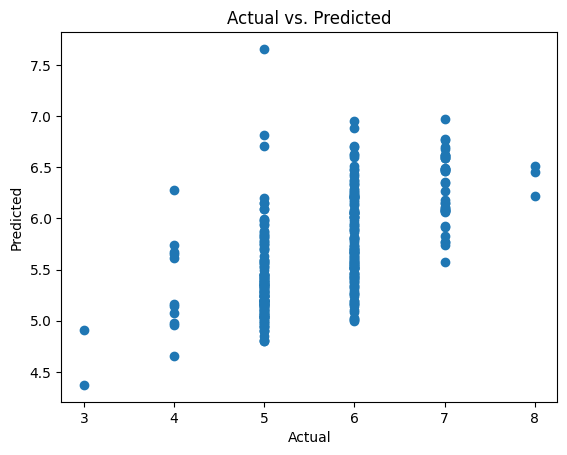

In [28]:
plot_actual_vs_predicted(test_data[outcome], predictions)

note: the model is not choosing any values as 3 or 4 and due to the nature of the model it is creating intemediate values that do not exist in the data. 

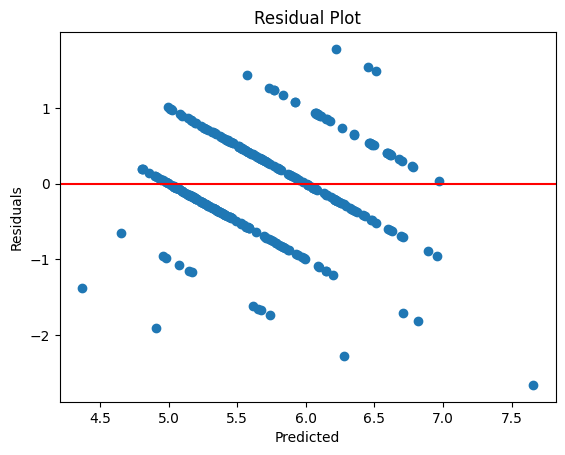

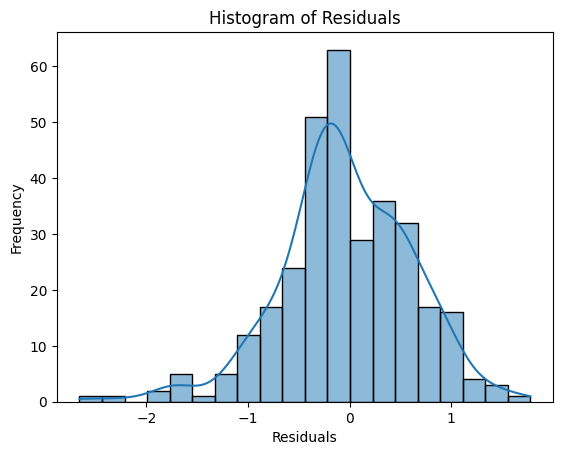

In [29]:
residuals = test_data[outcome] - predictions
plot_residuals(predictions, residuals)

removing insignificant features:

In [30]:
model = smf.ols(
    formula='quality ~ Q("volatile acidity") + chlorides + Q("total sulfur dioxide") + pH + sulphates + alcohol',
    data=train_data,
)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     114.8
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          6.81e-116
Time:                        15:08:21   Log-Likelihood:                -1265.8
No. Observations:                1279   AIC:                             2546.
Df Residuals:                    1272   BIC:                             2582.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

removing collinear features:

In [31]:
model = smf.ols(
    formula='quality ~ Q("volatile acidity") + Q("total sulfur dioxide") + sulphates + alcohol',
    data=train_data,
)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     160.9
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          1.72e-111
Time:                        15:08:23   Log-Likelihood:                -1281.2
No. Observations:                1279   AIC:                             2572.
Df Residuals:                    1274   BIC:                             2598.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Now this model has a similar R-squared, but much fewer features. 

In [32]:
predictors = [
    "volatile acidity",
    "total sulfur dioxide",
    "sulphates",
    "alcohol",
]
outcome = "quality"

model = LinearRegression()
model.fit(train_data[predictors], train_data[outcome])

predictions = model.predict(test_data[predictors])

print("R-squared:", r2_score(test_data[outcome], predictions))
print("Mean Squared Error:", mean_squared_error(test_data[outcome], predictions))
print(model.coef_)

R-squared: 0.36992949702507505
Mean Squared Error: 0.40656775932198386
[-1.17326656 -0.0014982   0.80772193  0.30062397]


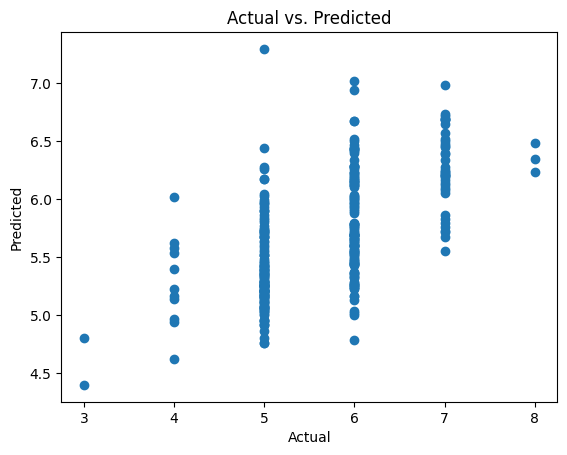

In [33]:
plot_actual_vs_predicted(test_data[outcome], predictions)

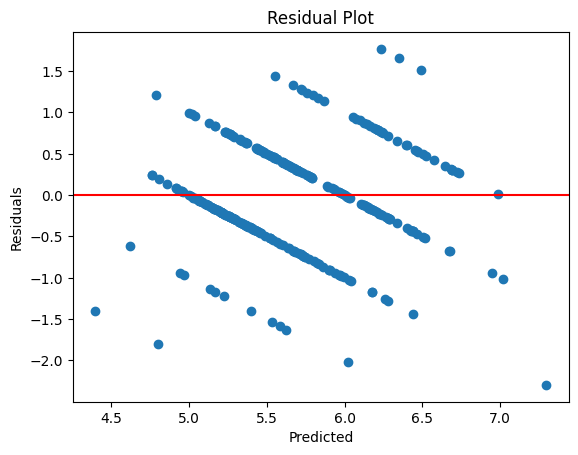

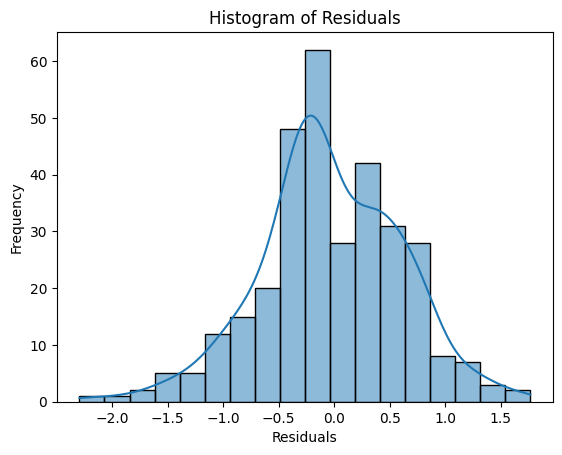

In [34]:
residuals = test_data[outcome] - predictions
plot_residuals(predictions, residuals)

By all indications, removing those extraneous features did not make the model perform much worse. However, given the type of data we are dealing with, this type of linear model is not appropriate.

I would like to try to use an ordinal model that could actually discern the various categories. However, I will instead choose a simpler approach

#### Logistic Regression
I will re-code my outcome variable as a binary variable and proceed to perform a logistic regression model: <br>
0 means quality score is 1-5<br>
1 means quality score is 6-10

In [35]:
wine_quality["quality_binary"] = wine_quality["quality"].apply(
    lambda x: 1 if x > 5 else 0
)

In [36]:
train_data, test_data = train_test_split(wine_quality, test_size=0.2)

In [37]:
predictors = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]
outcome = "quality_binary"

X = pd.get_dummies(train_data[predictors], prefix="", prefix_sep="", drop_first=True)
y = train_data[outcome]

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver="liblinear")
logit_reg.fit(X, y)

print("intercept ", logit_reg.intercept_[0])
print("classes", logit_reg.classes_)
pd.DataFrame({"coeff": logit_reg.coef_[0]}, index=X.columns)

intercept  -3.561000599911037
classes [0 1]


,coeff
fixed acidity,0.161276
volatile acidity,-3.776371
citric acid,-2.066327
residual sugar,-0.025796
chlorides,-3.662217
free sulfur dioxide,0.027753
total sulfur dioxide,-0.018200
density,-3.447894
pH,-0.681752
sulphates,2.686152


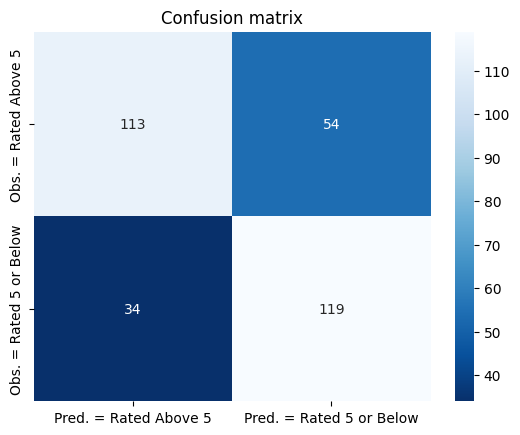

In [38]:
pred = logit_reg.predict(test_data[predictors])
pred_y = logit_reg.predict(test_data[predictors]) == 1
true_y = test_data[outcome] == 1
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame(
    [[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
    index=["Obs. = Rated Above 5", "Obs. = Rated 5 or Below"],
    columns=["Pred. = Rated Above 5", "Pred. = Rated 5 or Below"],
)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues_r")
plt.title("Confusion matrix")
plt.show()

In [39]:
print(f"accuracy: {accuracy_score(true_y, pred_y)}")
print(f"F1 score: {f1_score(true_y, pred_y)}")

accuracy: 0.725
F1 score: 0.7197452229299363


Area under ROC curve: 0.7923368948377755


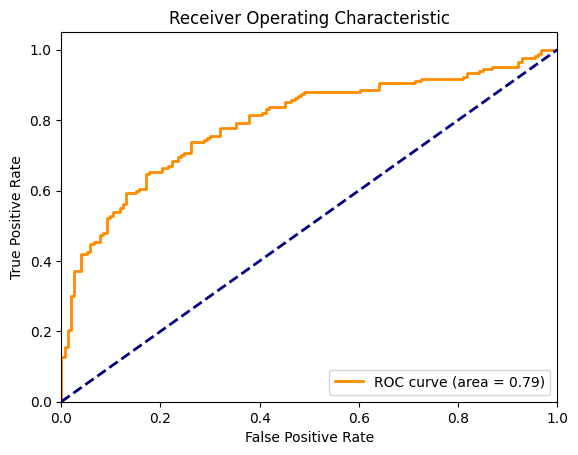

In [40]:
pred_prob = logit_reg.predict_proba(test_data[predictors])[:, 1]
threshold = 0.5
pred_y = pred_prob >= threshold
true_y = test_data[outcome] == 1

fpr, tpr, thresholds = roc_curve(true_y, pred_prob)
roc_auc = auc(fpr, tpr)
print(f"Area under ROC curve: {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc)

In [41]:
logit_reg_sm = sm.GLM(
    train_data[outcome],
    train_data[predictors].assign(const=1),
    family=sm.families.Binomial(),
)
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         quality_binary   No. Observations:                 1279
Model:                            GLM   Df Residuals:                     1267
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -652.06
Date:                Tue, 15 Oct 2024   Deviance:                       1304.1
Time:                        15:08:51   Pearson chi2:                 1.50e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3030
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.1268 

Now I will remove the features that are insignificant and collinear and repeat the process.

In [42]:
predictors = [
    "volatile acidity",
    "total sulfur dioxide",
    "sulphates",
    "alcohol",
]
outcome = "quality_binary"

logit_reg_sm = sm.GLM(
    train_data[outcome],
    train_data[predictors].assign(const=1),
    family=sm.families.Binomial(),
)
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         quality_binary   No. Observations:                 1279
Model:                            GLM   Df Residuals:                     1274
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -668.28
Date:                Tue, 15 Oct 2024   Deviance:                       1336.6
Time:                        15:08:52   Pearson chi2:                 1.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2850
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
volatile acidity        -3.2076 

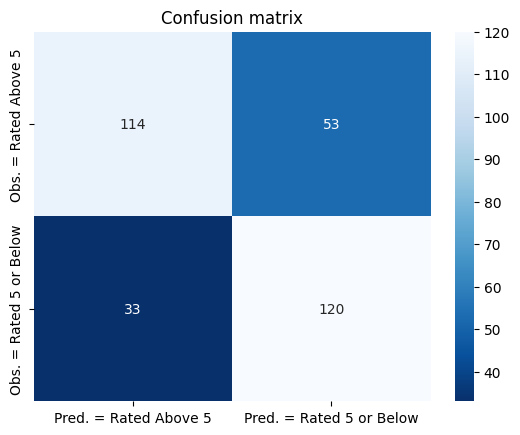

In [43]:
X = pd.get_dummies(train_data[predictors], prefix="", prefix_sep="", drop_first=True)
y = train_data[outcome]

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver="liblinear")
logit_reg.fit(X, y)

pred = logit_reg.predict(test_data[predictors])
pred_y = logit_reg.predict(test_data[predictors]) == 1
true_y = test_data[outcome] == 1
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame(
    [[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
    index=["Obs. = Rated Above 5", "Obs. = Rated 5 or Below"],
    columns=["Pred. = Rated Above 5", "Pred. = Rated 5 or Below"],
)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues_r")
plt.title("Confusion matrix")
plt.show()

In [44]:
print(f"accuracy: {accuracy_score(true_y, pred_y)}")
print(f"F1 score: {f1_score(true_y, pred_y)}")

accuracy: 0.73125
F1 score: 0.7261146496815286


Area under ROC curve: 0.8020821102892255


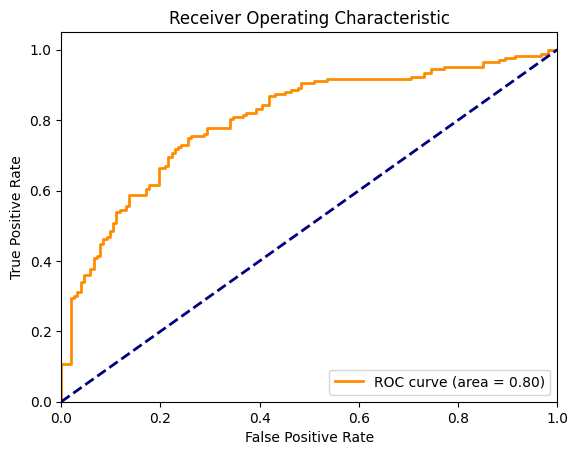

In [45]:
pred_prob = logit_reg.predict_proba(test_data[predictors])[:, 1]
threshold = 0.5
pred_y = pred_prob >= threshold
true_y = test_data[outcome] == 1

fpr, tpr, thresholds = roc_curve(true_y, pred_prob)
roc_auc = auc(fpr, tpr)
print(f"Area under ROC curve: {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc)

So now we have a simpler model that still has predictive power. 

***
### Can we predict alcohol from the red wine features? 

In [46]:
predictors = pd.Series(features[features != "alcohol"])
outcome = "alcohol"
model = sm.OLS(train_data[outcome], train_data[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          2.96e-314
Time:                        15:08:57   Log-Likelihood:                -1148.7
No. Observations:                1279   AIC:                             2321.
Df Residuals:                    1267   BIC:                             2383.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.4742 

First, I will remove insignificant features. 

In [47]:
predictors = ['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'density', 'pH', 'sulphates',
       'quality']
outcome = "alcohol"
model = sm.OLS(train_data[outcome], train_data[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     348.2
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          9.29e-314
Time:                        15:08:59   Log-Likelihood:                -1158.7
No. Observations:                1279   AIC:                             2335.
Df Residuals:                    1270   BIC:                             2382.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
fixed acidity        0.5075      0.021  

Multicollinearity is still a problem, but first I will do a partial residual plot to see how the data relates.

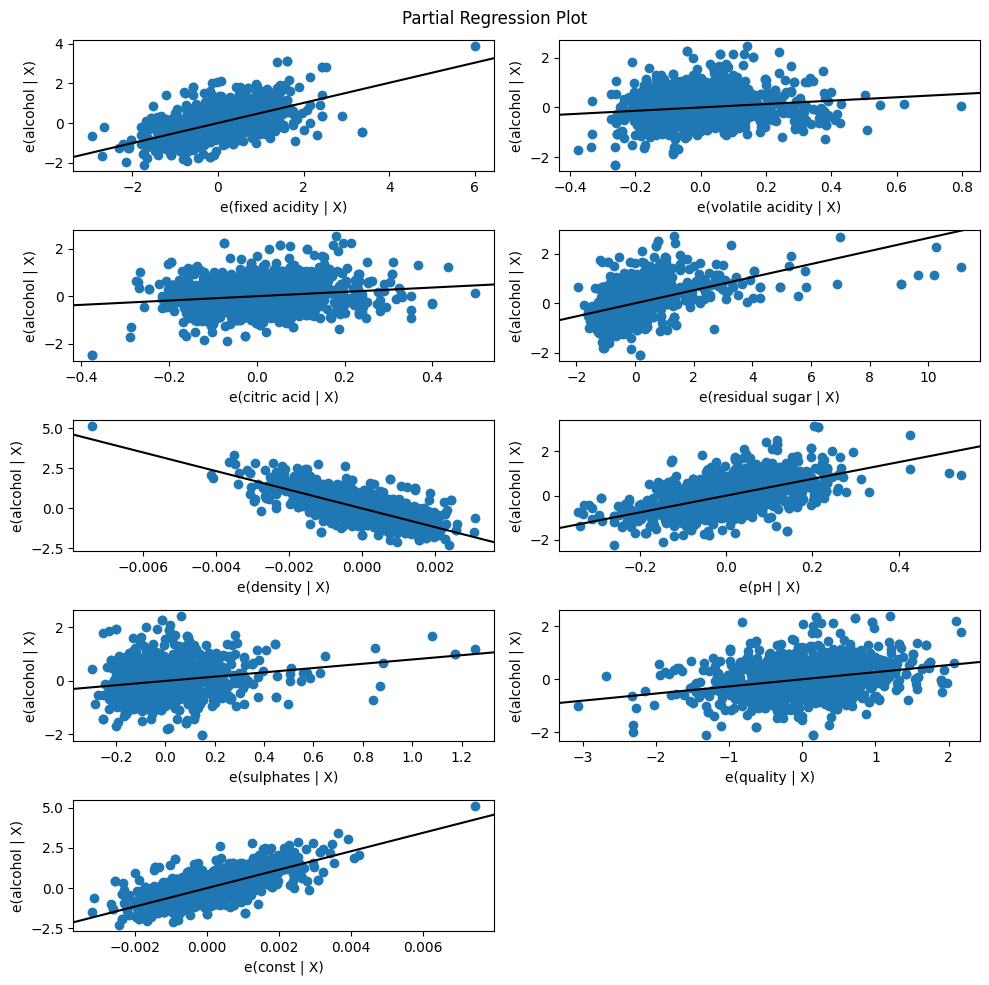

In [48]:
fig = plt.figure(figsize=(10, 10))
plot_partregress_grid(results, fig=fig)
plt.show()

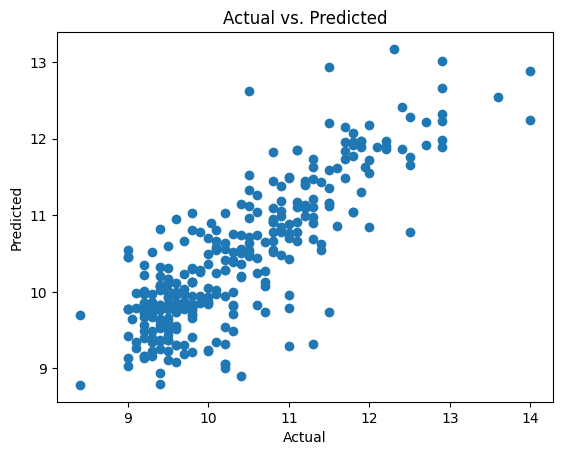

In [49]:
model = LinearRegression()
model.fit(train_data[predictors], train_data[outcome])
predictions = model.predict(test_data[predictors])
plot_actual_vs_predicted(test_data[outcome], predictions)

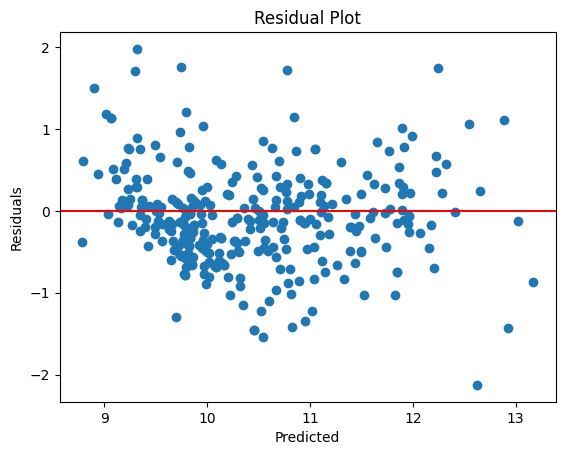

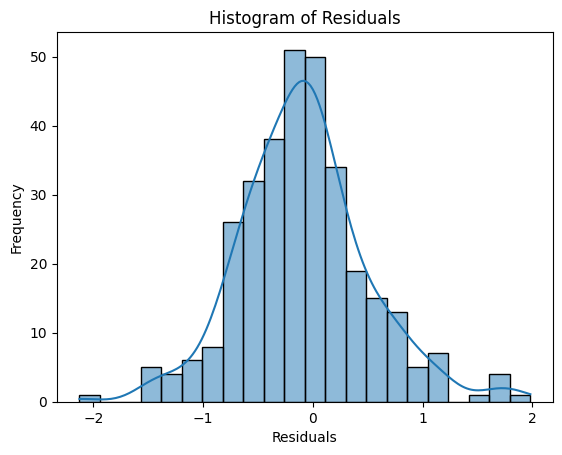

In [50]:
residuals = test_data[outcome] - predictions
plot_residuals(predictions, residuals)

In [51]:
print(f"Intercept: {model.intercept_:.3f}")
print("R-squared:", r2_score(test_data[outcome], predictions))
print("Mean Squared Error:", mean_squared_error(test_data[outcome], predictions))

Intercept: 571.346
R-squared: 0.6766423004362967
Mean Squared Error: 0.3518648210270006


note: this model seems quite good at this stage, but it may still struggle from collinearity. 

In [52]:
predictors = ['density']     
outcome = "alcohol"
model = sm.OLS(train_data[outcome], train_data[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     379.7
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           2.99e-74
Time:                        15:09:07   Log-Likelihood:                -1734.7
No. Observations:                1279   AIC:                             3473.
Df Residuals:                    1277   BIC:                             3484.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
density     -272.1675     13.967    -19.487      0.0

note: if I only include density, then you still have a condition number that indicates collinearity. Also note that density carries an R-squared value of .237. 

In [53]:
outcome = "alcohol"

model = LinearRegression()
model.fit(train_data[predictors], train_data[outcome])
y_pred = model.predict(test_data[predictors])

print(f"Intercept: {model.intercept_:.3f}")
print(f"Coefficient for density: {model.coef_[0]:.3f}")
print("R-squared:", r2_score(test_data[outcome], y_pred))
print("Mean Squared Error:", mean_squared_error(test_data[outcome], y_pred))

Intercept: 281.730
Coefficient for density: -272.168
R-squared: 0.3079708462173574
Mean Squared Error: 0.753038244240803


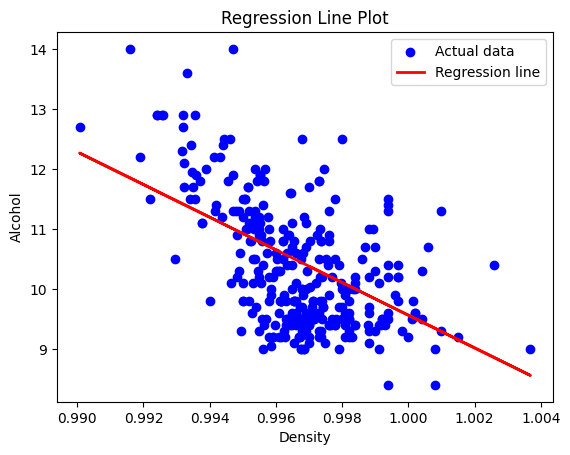

In [54]:
plt.scatter(
    test_data[predictors], test_data[outcome], color="blue", label="Actual data"
)

plt.plot(
    test_data[predictors], y_pred, color="red", linewidth=2, label="Regression line"
)

plt.xlabel("Density")
plt.ylabel("Alcohol")
plt.title("Regression Line Plot")
plt.legend()

plt.show()

# Conclusions
- Many features in this dataset are correlated with one another, making collinearity difficult to avoid and potentially causing overfitting of linear models
- scikit-learn's test_train_split function does not do a perfect job of pulling data that is commonly distributed
- Wine Quality can be predicted much better when simplified into a binary logistic regression problem
- Red Wine Quality is best predicted by: 
    - volatile acidity
        - best predictor of wine quality ratings being above or below 5
    - total sulfur dioxide
    - sulphates
    - alcohol
        
- Red Wine alcohol levels are best predicted by density.
 
Points for improvement:
- Feature Selection
- Consider use of Ordinal Models for Ordinal Data (e.g. OrderedModel in statsmodels)

[Dashboard of Conclusions](https://public.tableau.com/views/RedWineQuality_17133732879070/Dashboard1?:language=en-US&publish=yes&:sid=&:display_count=n&:origin=viz_share_link)

View on Tableau Public for best experience. 

In [55]:
# export data a json for use in Tableau
wine_quality.to_json("./data/wine_quality.json", orient="records")